In [41]:
# import needed libraries
import os
from os.path import join
from pathlib import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style= "darkgrid", color_codes = True)
import skimage
from skimage.io import imread,imshow
import cv2
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Sequential
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [42]:
# define the data path

data_path = Path('D:/year 3/Graduation Project/chest_xray')

train_path = data_path / 'train'
val_path = data_path / 'val'
test_path = data_path / 'test'
train_path


WindowsPath('D:/year 3/Graduation Project/chest_xray/train')

In [43]:
# define the path for normal and pneuonia cases

normal_cases_path = train_path / 'NORMAL'
pneumonia_cases_path = train_path / 'PNEUMONIA'

# find path of all normal and pneumonia images

normal_cases = normal_cases_path.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_path.glob('*.jpeg')

# make a panda data frame with the images path and each labels

train_data = []

for image in normal_cases:
    train_data.append((image,0))
    
for image in pneumonia_cases:
    train_data.append((image, 1))
    
train_df = pd.DataFrame(train_data, columns=['image', 'label'])


# print the first f rows of the data frame  

train_df.head()


,image,label
0,D:\year 3\Graduation Project\chest_xray\train\...,0
1,D:\year 3\Graduation Project\chest_xray\train\...,0
2,D:\year 3\Graduation Project\chest_xray\train\...,0
3,D:\year 3\Graduation Project\chest_xray\train\...,0
4,D:\year 3\Graduation Project\chest_xray\train\...,0


In [44]:
# count the labels 

count = train_df['label'].value_counts()
print(count)


1    3875
0    1341
Name: label, dtype: int64


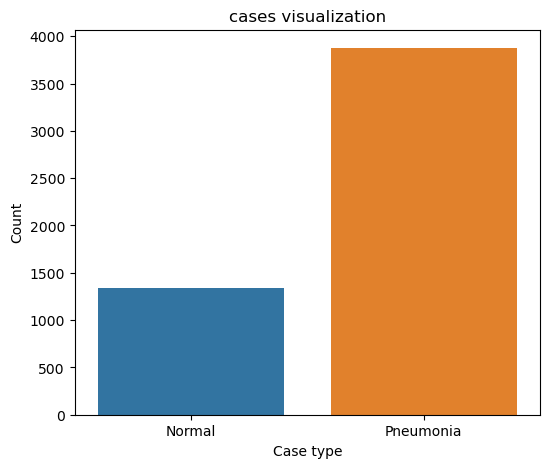

In [45]:
# plot the label distribution

plt.figure(figsize=(6,5))
sns.barplot(x=count.index, y=count.values)
plt.title('cases visualization', fontsize=12)
plt.xlabel('Case type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.show()

In [46]:
# store the number of normal and pneumonia cases count

normal_count = (train_df['label'].values == 0).sum()

pneumonia_count = (train_df['label'].values == 1).sum()

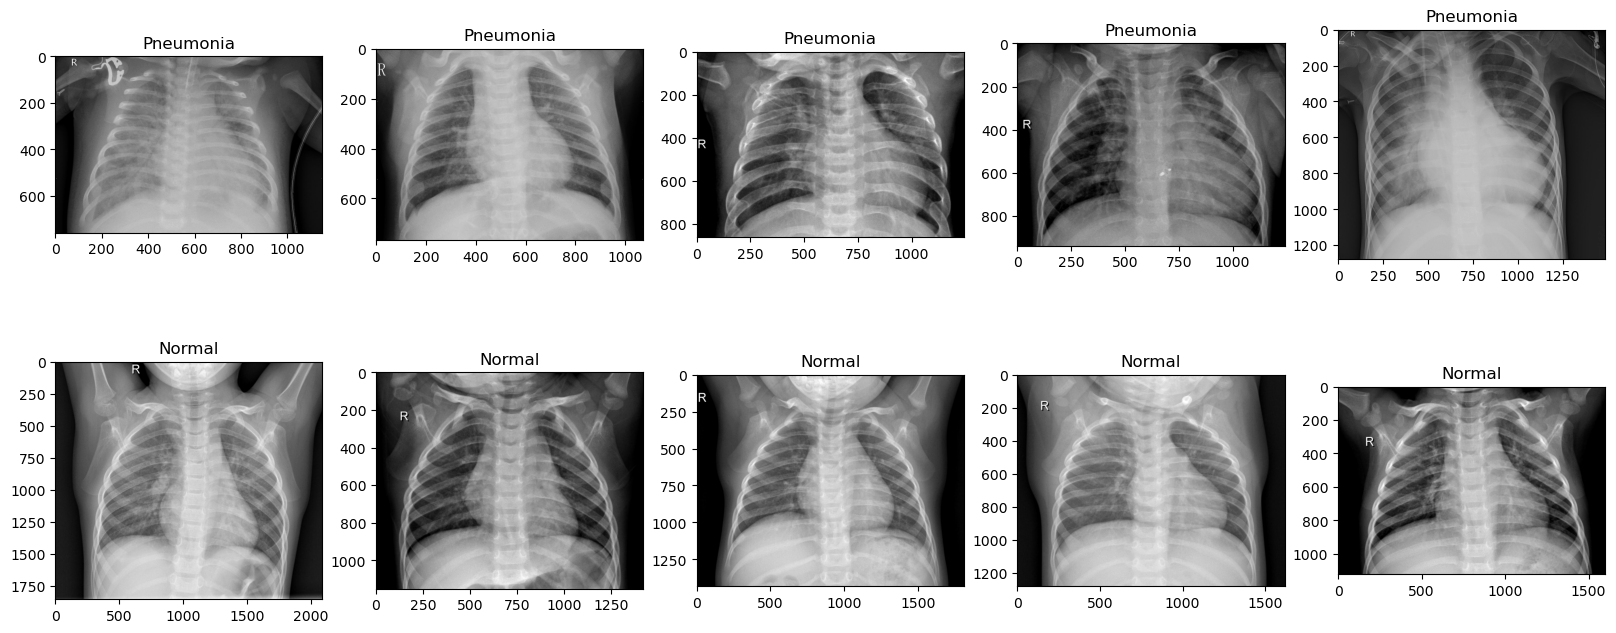

In [47]:
# get some samples for both classes

pn = train_df['label']==1
nor = train_df['label']==0

pneumonia = (train_df[pn]['image'].iloc[:5]).tolist()
normal = (train_df[nor]['image'].iloc[:5]).tolist()

# merge the data in single list and delete the old lists

samples = pneumonia + normal
del pneumonia, normal

# Plotting

f, ax = plt.subplots(2,5, figsize=(20,8))

for i in range(10):
    img = imread(samples[i])
    
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")

    
plt.show()

In [50]:
labels = ['NORMAL','PNEUMONIA']       
img_dim = 150                         # image size

# define a function that prepare our training, testin and validation data

def get_data(data_path):
    
    data = []
    
    for x in labels: 
        path = os.path.join(data_path,x)
        label_index = labels.index(x)
        
        for image in os.listdir(path):
            
            gray_img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)   # read image and convert to grayscale
            resized_img = cv2.resize(gray_img, (img_dim, img_dim))
            data.append([resized_img, label_index])
            
    return data

In [51]:
# get the training, testing and validation data

train = get_data(train_path)
test = get_data(test_path)
val = get_data(val_path)

In [52]:
# split the data into x and y or (image and label)

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for image, label in train:
    x_train.append(image)
    y_train.append(label)

for image, label in test:
    x_test.append(image)
    y_test.append(label)
    
for image, label in val:
    x_val.append(image)
    y_val.append(label)
    



In [53]:
# normalize the data

x_train = np.array(x_train)/255
x_test = np.array(x_test)/255
x_val = np.array(x_val)/255


print(x_train.shape)
print(x_test.shape)
print(x_val.shape)


(5216, 150, 150)
(624, 150, 150)
(16, 150, 150)


In [54]:
# reshape the data for deep learning

x_train = x_train.reshape(-1, img_dim, img_dim, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_dim, img_dim, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_dim, img_dim, 1)
y_test = np.array(y_test)



print(x_val.shape)


(16, 150, 150, 1)


In [55]:
# data augmentation to prevent overfitting and handling the imbalance in dataset
# define data generator object (aug)

aug = ImageDataGenerator(
       
        rotation_range = 30,     # randomly rotate images in the range from zero to 30
        zoom_range = 0.2,        # Randomly zoom image by 20 % 
        width_shift_range=0.1,   # randomly shift images horizontally by 10 %
        height_shift_range=0.1,  # randomly shift images vertically by 10 %
        horizontal_flip = True,  # randomly flip images horizontaly 
) 

# fit the data with the generator

aug.fit(x_train)

In [24]:
# build the CNN model

model = Sequential()

model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , padding = 'same'))

model.add(Conv2D(64 , (3,3)  , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)  , padding = 'same'))

model.add(Conv2D(64 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) ,  padding = 'same'))

model.add(Conv2D(128 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , padding = 'same'))

model.add(Conv2D(256 , (3,3)  , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

In [25]:
model.summary()                   # print the model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [26]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])   # compile the model


In [27]:
# define callback that reduce learning rate

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, min_lr=0.000001, patience = 2, verbose=1) 


In [28]:
history = model.fit(aug.flow(x_train,y_train, batch_size = 32), validation_data = aug.flow(x_val, y_val), epochs = 14 , callbacks = [reduce_lr])

Epoch 1/14
163/163 [==============================] - 145s 837ms/step - loss: 0.4910 - accuracy: 0.8332 - val_loss: 35.4747 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/14
163/163 [==============================] - 124s 745ms/step - loss: 0.2751 - accuracy: 0.8944 - val_loss: 26.2772 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/14
163/163 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9197
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 135s 816ms/step - loss: 0.2151 - accuracy: 0.9197 - val_loss: 47.3345 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/14
163/163 [==============================] - 139s 839ms/step - loss: 0.1360 - accuracy: 0.9530 - val_loss: 9.0018 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/14
163/163 [==============================] - 149s 900ms/step - loss: 0.1274 - accuracy: 0.9509 - val_loss: 3.7131 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/14
163/163 [=============

In [29]:
# predict and evaluate the model

loss = model.evaluate(x_test,y_test)[0]
acc = model.evaluate(x_test,y_test)[1]*100

print("the Loss of the model is   " , loss)
print("Accuracy of the model is   " , acc, "%")

20/20 [==============================] - 6s 141ms/step - loss: 0.2328 - accuracy: 0.9231
the Loss of the model is    0.23275624215602875
Accuracy of the model is    92.30769276618958 %


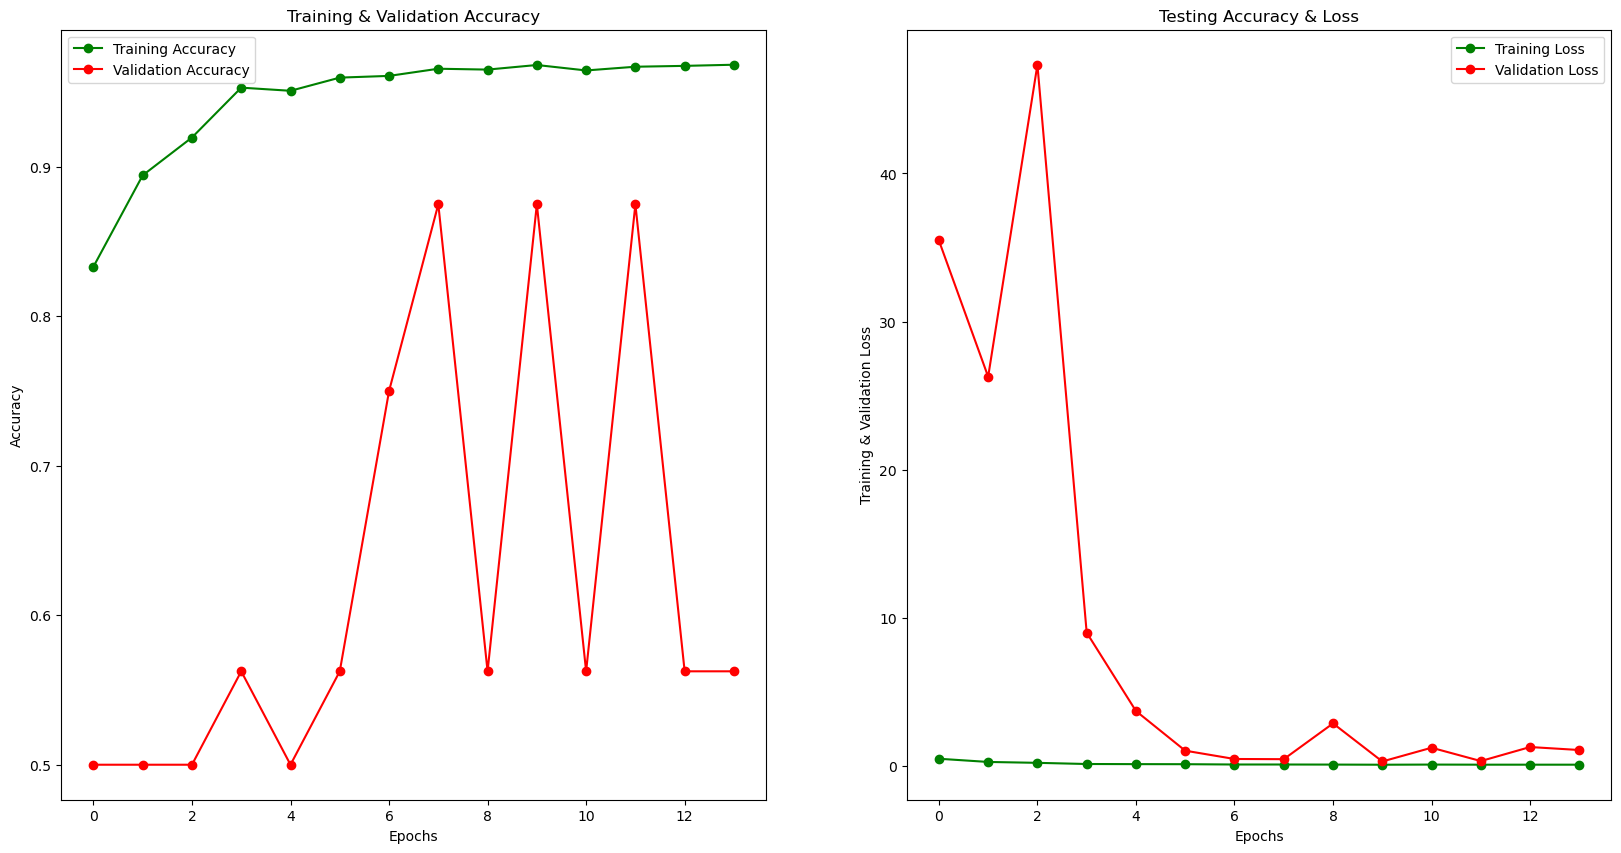

In [30]:
epochs = [i for i in range(14)]
fig , ax = plt.subplots(1,2)

# save the model accuracies 

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

# plot the train and validation accuracy curve

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# plot the train and validation loss curve

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")

# show the figure

plt.show()

In [36]:
prediction = model.predict(x_test)
prediction = (prediction > 0.5).astype(int)



20/20 [==============================] - 6s 150ms/step


In [37]:
print(classification_report(y_test, prediction, target_names = ['Normal (0)','pneumonia (1)']))  #print the classification report

               precision    recall  f1-score   support

   Normal (0)       0.91      0.88      0.90       234
pneumonia (1)       0.93      0.95      0.94       390

     accuracy                           0.92       624
    macro avg       0.92      0.91      0.92       624
 weighted avg       0.92      0.92      0.92       624



In [38]:
confusion_matrix = confusion_matrix(y_test,prediction)            # confusion matrix
print(confusion_matrix)

[[206  28]
 [ 20 370]]


In [39]:
confusion_matrix = pd.DataFrame(confusion_matrix , index = ['0','1'] , columns = ['0','1'])    # put it in a data frame
print(confusion_matrix)

     0    1
0  206   28
1   20  370


<Axes: >

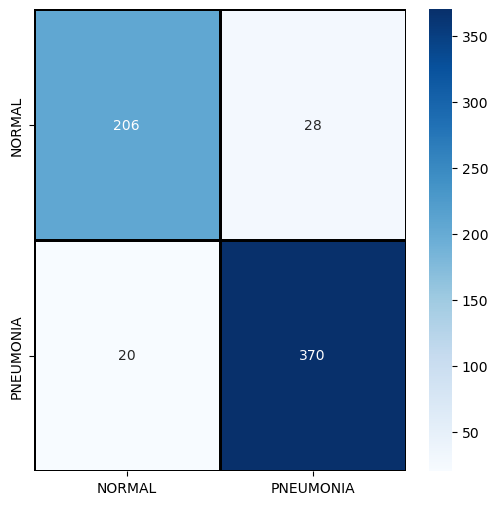

In [40]:
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix, cmap= "Blues", linecolor = 'black', linewidth = 2 , annot = True, fmt='', xticklabels = labels,yticklabels = labels)


### VGG16 model

In [60]:
# Save the model
model.save('CNN_model.h5')
print ("Model saved successfully!")

C:\Users\kamunna\anaconda33\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!
